In [1]:
import sys
sys.path.append("..")
from lazydiff.vars import Var
from lazydiff import ops
import numpy as np
from lazydiff import regression

import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
%matplotlib notebook

In [2]:
dim = 1

In [3]:
X,y,true_coef = make_regression(n_samples = 100, n_features = dim, n_informative = dim, bias = 10, \
                                coef = True, noise = 0, random_state=1)

Let's first look at how our iterative regression updates over each epoch!

<IPython.core.display.Javascript object>


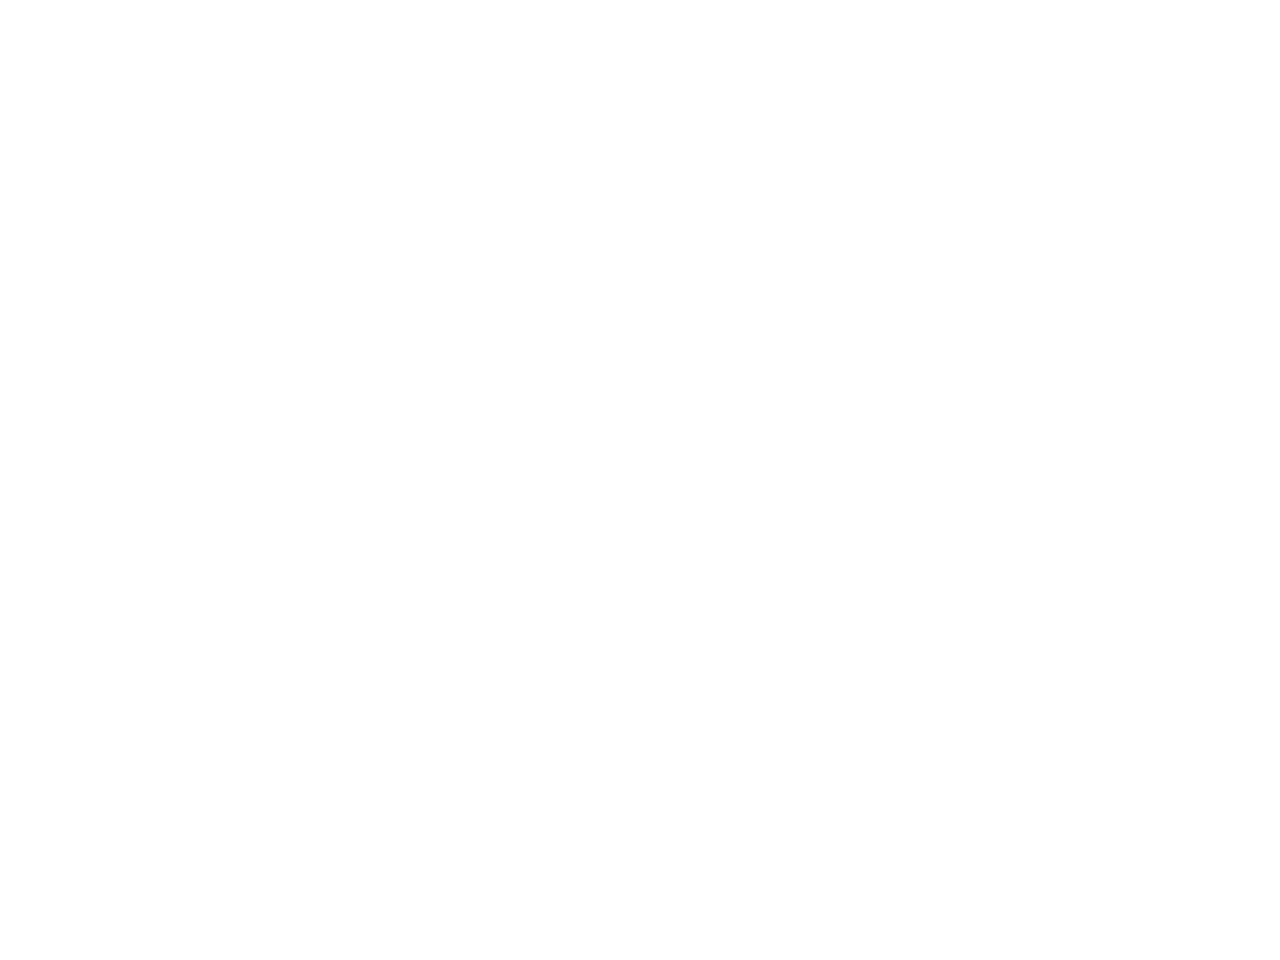

<IPython.core.display.Javascript object>


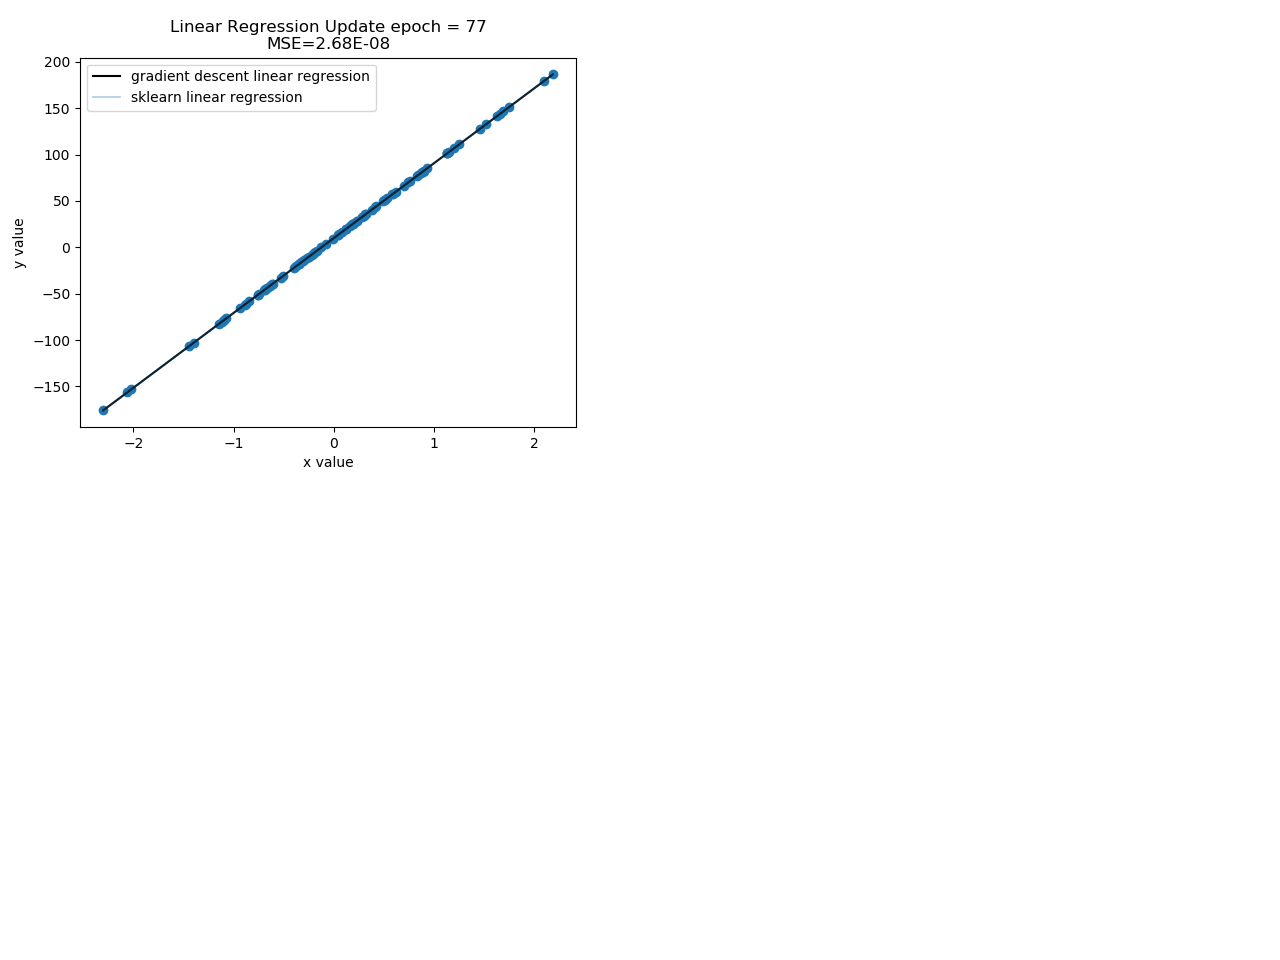

Time Elapsed 48.91855812072754


In [4]:
%matplotlib notebook

m = Var(np.ones(X.shape[1]))
b = Var(0)
earlyStop = 1e-8
plot = True
forward = True
(m, b, loss), elapsed = regression.iterative_regression(X, y, m, b, regression.MSE, 0.1, 100,
                                                    earlyStop, forward, plot)

In [5]:
# linear regression
clf = LinearRegression().fit(X,y)
## check that getting close results
print("Difference between iterative and sklearn linear regression")
print("Coefficient: {}".format(m.val - clf.coef_))
print("Intercept: {}".format(b.val - clf.intercept_))

Difference between iterative and sklearn linear regression
Coefficient: [-0.00012909]
Intercept: 3.367222182149021e-05


Now let's test how much time forward and reverse mode (backpropagation) take to get the gradients.

Since increasing by a dimension of 100 is not very noticeable, we decide to increase by 1000 each time.

In [6]:
time_forward = []
time_backward = []
dim_range = np.arange(10,11000,1000)
# checking performance varying dimension
for dim in dim_range:
    print("working on dim={}".format(dim), end='\r')
    X, y= make_regression(n_samples = 100, n_features = dim, n_informative = dim, bias = 10, \
                                coef = False, noise = 0, random_state=1)
    # no earlyStop
    earlyStop = 0
    
    forward = True
    m = Var(np.ones(X.shape[1]))
    b = Var(0)
    _, elapsed = regression.iterative_regression(X, y, m, b, regression.MSE, 0.1, 100, earlyStop, forward)
    time_forward.append(elapsed)
    
    forward = False
    m = Var(np.ones(X.shape[1]))
    b = Var(0)
    _, elapsed = regression.iterative_regression(X, y, m, b, regression.MSE, 0.1, 100, earlyStop, forward)
    time_backward.append(elapsed)

Time Elapsed 1.6302590370178223
Time Elapsed 1.2701778411865234
Time Elapsed 2.11293888092041
Time Elapsed 1.5329039096832275
Time Elapsed 2.524609088897705
Time Elapsed 1.5580737590789795
Time Elapsed 2.9460580348968506
Time Elapsed 1.7334470748901367
Time Elapsed 3.644972085952759
Time Elapsed 1.856579065322876
Time Elapsed 3.9305408000946045
Time Elapsed 2.0806047916412354
Time Elapsed 4.412793159484863
Time Elapsed 2.6817710399627686
Time Elapsed 4.949193954467773
Time Elapsed 3.0759170055389404
Time Elapsed 5.4332451820373535
Time Elapsed 2.6095330715179443
Time Elapsed 6.308966875076294
Time Elapsed 2.9342191219329834
Time Elapsed 6.820434808731079
Time Elapsed 2.7373831272125244


<IPython.core.display.Javascript object>


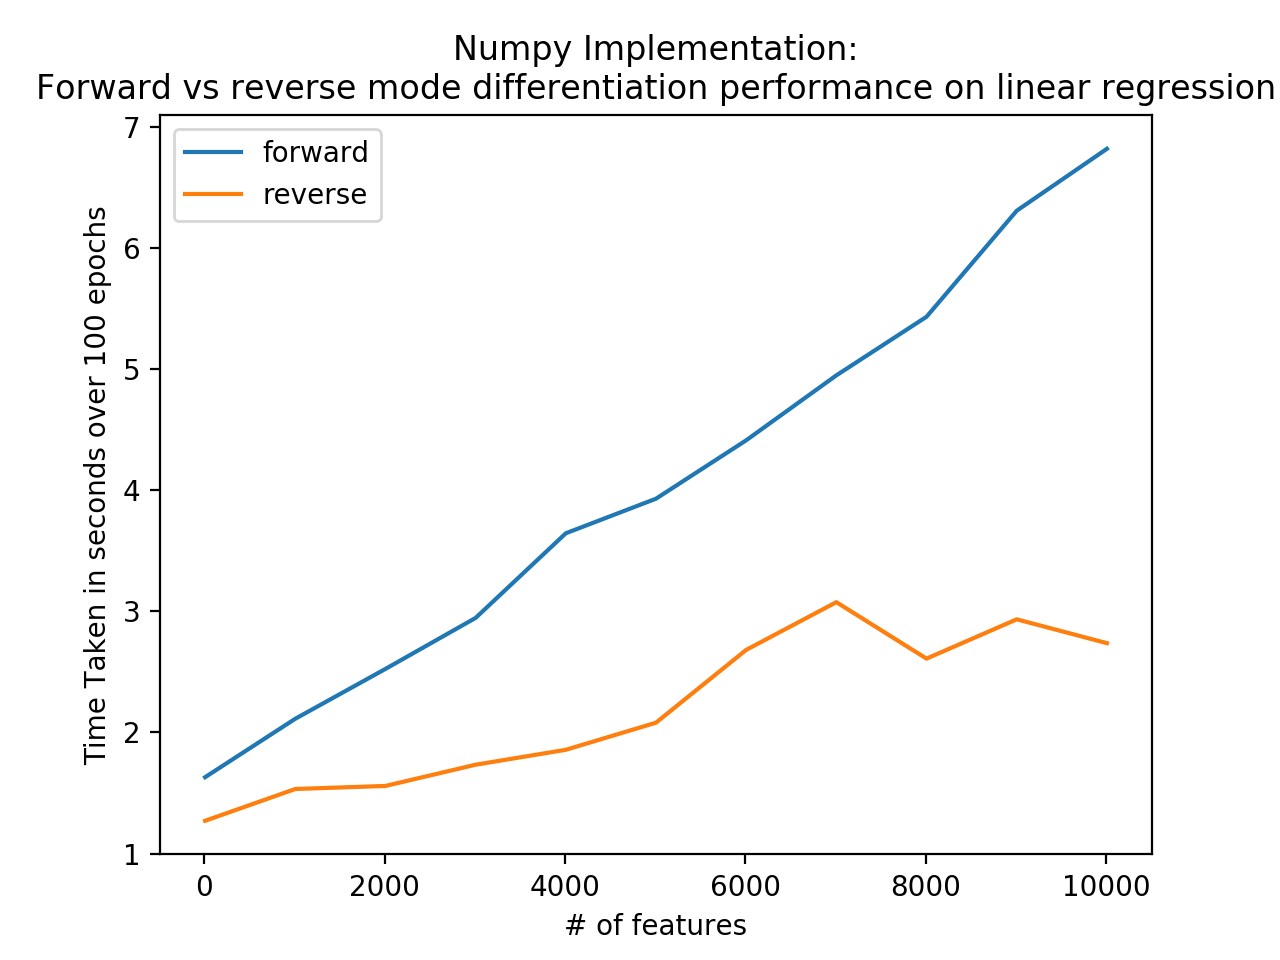

Text(0.5, 1.0, 'Numpy Implementation:\nForward vs reverse mode differentiation performance on linear regression')

In [7]:
%matplotlib notebook
plt.figure()
plt.plot(dim_range, time_forward, label='forward')
plt.plot(dim_range, time_backward, label='reverse')
plt.legend()
plt.xlabel("# of features")
plt.ylabel("Time Taken in seconds over 100 epochs")
plt.title("Numpy Implementation:\nForward vs reverse mode differentiation performance on linear regression")

The result looks as expected, where the increase of forward mode is much steeper than the reverse mode. This shows how backpropagation is better than forward mode in cases where there are a lot of inputs to the loss, but small number of outputs.

#### Lasso, Ridge and Elastic Net

Let's now test that our Lasso, Ridge and Elastic Net implementation also work correctly with some noisy regression data

In [8]:
dim = 2
X,y,true_coef = make_regression(n_samples = 100, n_features = dim, n_informative = dim, bias = 10, \
                                coef = True, noise = 1, random_state=1)

In [9]:
m_lasso = Var(np.ones(X.shape[1]))
b_lasso = Var(0)
earlyStop = 0 #1e-8
plot = False
forward = False
epochs = 300
lr = 0.1
(m_lasso, b_lasso, loss), elapsed = regression.iterative_regression(X, y, m_lasso, b_lasso, regression.lasso_loss, lr, epochs,
                                                    earlyStop, forward, plot)

Time Elapsed 3.6530208587646484


In [10]:
## check that we're getting close results
clf_l1 = Lasso().fit(X,y)
print("Difference between iterative and sklearn Ridge regression")
print("Coefficient: {}".format(m_lasso.val - clf_l1.coef_))
print("Intercept: {}".format(b_lasso.val - clf_l1.intercept_))

Difference between iterative and sklearn Ridge regression
Coefficient: [8.63388706e-05 1.30656280e-05]
Intercept: -1.6942516758433612e-06


In [11]:
m_ridge = Var(np.ones(X.shape[1]))
b_ridge = Var(0)
earlyStop = 0 #1e-8
plot = False
forward = False
epochs = 300
# need to use a very small learning rate for Ridge
# if not it blows up
lr = 0.001
(m_ridge, b_ridge, loss), elapsed = regression.iterative_regression(X, y, m_ridge, b_ridge, regression.ridge_loss, lr, epochs,
                                                    earlyStop, forward, plot)

Time Elapsed 3.8102471828460693


In [12]:
## check that we're getting close results
clf_l2 = Ridge().fit(X,y)
print("Difference between iterative and sklearn Ridge regression")
print("Coefficient: {}".format(m_ridge.val - clf_l2.coef_))
print("Intercept: {}".format(b_ridge.val - clf_l2.intercept_))

Difference between iterative and sklearn Ridge regression
Coefficient: [0. 0.]
Intercept: -8.881784197001252e-15


In [13]:
m_el = Var(np.ones(X.shape[1]))
b_el = Var(0)
earlyStop = 0 #1e-8
plot = False
forward = False
epochs = 300
lr = 0.1
(m_el, b_el, loss), elapsed = regression.iterative_regression(X, y, m_el, b_el, regression.elastic_loss, lr, epochs,
                                                    earlyStop, forward, plot)

Time Elapsed 3.7644031047821045


In [14]:
## check that we're getting close results
clf_el = ElasticNet().fit(X,y)
print("Difference between iterative and sklearn Ridge regression")
print("Coefficient: {}".format(m_el.val - clf_el.coef_))
print("Intercept: {}".format(b_el.val - clf_el.intercept_))

Difference between iterative and sklearn Ridge regression
Coefficient: [1.80313935e-06 1.66684259e-07]
Intercept: -1.3828518774516851e-08


All the results are similar to that of sklearn, this means our regression extensions are working correctly!